In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
layers = keras.layers
import matplotlib.pyplot as plt
F = keras.activations
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
tfd = tfp.distributions
import pickle
import etas_pkl
import importlib

In [25]:
DEBUG = False
def debug(msg):
    if DEBUG:
        print(msg)


class Distribution:
    def prob(self, x):
        raise NotImplementedError


    def log_prob(self, x):
        raise NotImplementedError


    def survival(self, x):
        raise NotImplementedError


    def log_survival(self, x):
        raise NotImplementedError


    def sample(self, shape):
        raise NotImplementedError


class Gamma(Distribution):
    name = "gamma"
    n_params = 2


    def __init__(self, alpha, beta):
        self.eps = 1e-08
        self.alpha = tf.clip_by_value(alpha, self.eps, tf.reduce_max(alpha))
        self.beta = tf.clip_by_value(beta, self.eps, tf.reduce_max(beta))


    def prob(self, x):
        return tf.math.exp(self.log_prob(x))


    def log_prob(self, x):
        x = tf.clip_by_value(x, self.eps, tf.reduce_max(x))
        return (self.alpha - 1) * tf.math.log(x) \
            + self.alpha * tf.math.log(self.beta) \
            - self.beta * x \
            - tf.math.lgamma(self.alpha)


    def survival(self, x):
        return tf.math.exp(self.log_survival(x))


    def log_survival(self, x):
        x = tf.clip_by_value(x, self.eps, tf.reduce_max(x))
        y = 1 - tf.math.igamma(self.alpha, self.beta * x) \
            / tf.math.exp(tf.math.lgamma(self.alpha))
        y = tf.clip_by_value(y, self.eps, tf.reduce_max(y))
        return tf.math.log(y)


class Weibull(Distribution):
    name = "weibull"
    n_params = 2


    def __init__(self, k, lambd):
        self.eps = 1e-08
        self.k = tf.clip_by_value(k, self.eps, tf.reduce_max(k))
        self.lambd = tf.clip_by_value(lambd, self.eps, tf.reduce_max(lambd))


    def prob(self, x):
        return tf.math.exp(self.log_prob(x))


    def log_prob(self, x):
        x = tf.clip_by_value(x, self.eps, tf.reduce_max(x))
        return tf.math.log(self.k) - self.k * tf.math.log(self.lambd) \
            + (self.k - 1) * tf.math.log(x) \
            - tf.math.pow(x, self.k) / tf.math.pow(self.lambd, self.k)


    def survival(self, x):
        return tf.math.exp(self.log_survival(x))


    def log_survival(self, x):
        x = tf.clip_by_value(x, self.eps, tf.reduce_max(x))
        return -tf.math.pow(x, self.k) / tf.math.pow(self.lambd, self.k)


class Mixture(Distribution):
    def __init__(self, weights, dist):
        if not isinstance(dist, Distribution):
            raise ValueError("Distribution is not supported")
        self.weights = tf.Variable(weights, dtype=tf.float32)
        self.dist = dist


    def prob(self, x):
        x = tf.expand_dims(x, axis=-1)
        return tf.squeeze(tf.reduce_sum(self.weights * self.dist.prob(x), axis=-1))


    def log_prob(self, x):
        y = self.prob(x)
        y = tf.clip_by_value(y, self.dist.eps, tf.reduce_max(y))
        return tf.math.log(y)


    def survival(self, x):
        x = tf.expand_dims(x, axis=-1)
        return tf.squeeze(tf.reduce_sum(self.weights * self.dist.survival(x), axis=-1))


    def log_survival(self, x):
        y = self.survival(x)
        y = tf.clip_by_value(y, self.dist.eps, tf.reduce_max(y))
        return tf.math.log(y)


class Model:
    def __init__(self, context_size=32, dist=Weibull, num_cmpts=1, lr=5e-3):
        if not issubclass(dist, Distribution):
            raise ValueError("Distribution is not supported")
        self.context_size = context_size
        self.encoder = keras.layers.GRU(context_size, return_sequences=True)
        # self.decoder = keras.layers.Dense((dist.n_params + 1) * num_cmpts)
        self.decoder = keras.layers.Dense(num_cmpts * (dist.n_params + 1))
        self.optimizer = keras.optimizers.Adam(learning_rate=lr)
        self.dist = dist
        self.num_cmpts = num_cmpts
        self.params = []
        if num_cmpts > 1:
            print(f"Model will train with a mixture of {num_cmpts} \
{dist.name.title()} distributions")
        else:
            print(f"Model will train with a {dist.name.title()} distribution")


    def get_context(self, inter_times):
        tau = tf.expand_dims(inter_times, axis=-1)
        log_tau = tf.math.log(tf.clip_by_value(tau, 1e-8, tf.reduce_max(tau)))
        input = tf.concat([tau, log_tau], axis=-1)
        output = self.encoder(input)
        context = tf.pad(output[:, :-1, :], [[0, 0], [1, 0], [0, 0]])
        return context


    def get_inter_times_distribution(self, context):
        params = self.decoder(context)
        # debug(f"params.shape = {params.shape}")
        weights = F.softmax(params[..., :self.num_cmpts])
        self.params.append({"weights": weights})
        # debug(f"weights.shape = {weights.shape}")
        params_list = []
        for i in range(1, self.dist.n_params + 1):
            params_list.append(F.softplus(params[..., i * self.num_cmpts:(i+1) * self.num_cmpts]))
            self.params[-1][f"param_{i}"] = params_list[-1]
        
        # for param in params_list:
        #     debug(f"param.shape = {param.shape}")
        debug(f"{params_list[0][-1, -1, -1]:.2f}, {params_list[1][-1, -1, -1]:.2f}")
        return Mixture(weights, self.dist(*params_list))


    def nll_loss(self, inter_times, seq_lengths):
        context = self.get_context(inter_times)
        inter_times_dist = self.get_inter_times_distribution(context)

        # inter_times = tf.expand_dims(inter_times, axis=-1)
        log_pdf = inter_times_dist.log_prob(inter_times)
        log_surv = inter_times_dist.log_survival(inter_times)

        # debug(f"log_pdf.shape =, {log_pdf.shape}")
        # debug(f"log_surv.shape = {log_surv.shape}")

        # debug(f"log_pdf {np.sum(np.isnan(log_pdf))}")
        # debug(f"log_surv {np.sum(np.isnan(log_surv))}")

        # construit un masque pour ne sélectionner que les éléments
        # nécessaires dans chaque liste
        mask = np.cumsum(np.ones_like(log_pdf), axis=-1) \
            <= np.expand_dims(seq_lengths, axis=-1)
        log_like = tf.reduce_sum(log_pdf * mask, axis=-1)

        # print("log_pdf * mask ", np.sum(np.isnan(log_pdf * mask)))
        
        # idx est une liste de la forme [(a1, b1), (a2, b2), ...]
        # gather_nd sélectionne les éléments correspondant à ces indices
        # (ligne et colonne)
        idx = list(zip(range(len(seq_lengths)), seq_lengths))
        log_surv_last = tf.gather_nd(log_surv, idx)
        # print("log_surv_last ", np.sum(np.isnan(log_surv_last)))
        log_like += log_surv_last

        return -log_like
    

    @property
    def weights(self):
        return self.encoder.trainable_weights + self.decoder.trainable_weights


    def fit(self, epochs, inter_times, seq_lengths, t_end):
        for epoch in range(epochs + 1):
            with tf.GradientTape() as tape:
                loss = tf.reduce_mean(self.nll_loss(inter_times,
                                                    seq_lengths)) / t_end
            grads = tape.gradient(loss, self.weights)
            # debug(f"grads {np.sum([np.sum(np.isnan(grad)) for grad in grads])}")
            self.optimizer.apply_gradients(zip(grads, self.weights))

            if epoch % 10 == 0:
                print(f"Loss at epoch {epoch}: {loss:.2f}")

In [26]:
file = open("dataset.pkl", "rb")
data = pickle.load(file)
t_end = data["t_end"]
arrival_times = data["arrival_times"]

seq_lengths = [len(times) for times in arrival_times]
inter_times_list = [np.diff(times, prepend=0, append=t_end)
                    for times in arrival_times]

inter_times = np.asarray([np.pad(inter_times, (0, np.max(seq_lengths) - size))
        for size, inter_times in zip(seq_lengths, inter_times_list)])

inter_times = tf.Variable(inter_times, dtype=tf.float32)

model = Model(context_size=32, dist=Weibull, num_cmpts=1)
model.fit(80, inter_times, seq_lengths, t_end)

Model will train with a Weibull distribution
Loss at epoch 0: 0.97
Loss at epoch 10: 0.82
Loss at epoch 20: 0.80
Loss at epoch 30: 0.79
Loss at epoch 40: 0.78
Loss at epoch 50: 0.77
Loss at epoch 60: 0.77
Loss at epoch 70: 0.77
Loss at epoch 80: 0.77


### Vérification avec des lois classiques (mélanges à une composante)

In [27]:
def train_and_plot_params(samples_dist, samples_shape=(100, 100), train_dist=Weibull, num_epochs=100, params=None):
    inter_times = samples_dist.sample(samples_shape)
    arrival_times = np.cumsum(inter_times, axis=-1)
    eps = 1e-8
    t_end = np.min(arrival_times[:, -1]) - eps
    seq_lengths = np.sum(arrival_times < t_end, axis=-1)

    model = Model(context_size=32, dist=train_dist, num_cmpts=1)
    model.fit(num_epochs, inter_times, seq_lengths, t_end)

    epochs = np.arange(len(model.params))
    b_list = [np.mean(model.params[i]["param_1"][:, -1, 0]) for i in epochs]
    k_list = [np.mean(model.params[i]["param_2"][:, -1, 0]) for i in epochs]
    plt.scatter(epochs + 1, b_list, marker="s", alpha=0.4)
    plt.scatter(epochs + 1, k_list, marker="^", alpha=0.4)
    for param in params:
        plt.axhline(param)
    plt.grid()
    plt.show()

    return model.params

Model will train with a Weibull distribution
Loss at epoch 0: 0.92
Loss at epoch 10: 0.58
Loss at epoch 20: 0.58
Loss at epoch 30: 0.57
Loss at epoch 40: 0.57
Loss at epoch 50: 0.57
Loss at epoch 60: 0.57
Loss at epoch 70: 0.57
Loss at epoch 80: 0.57
Loss at epoch 90: 0.57
Loss at epoch 100: 0.57


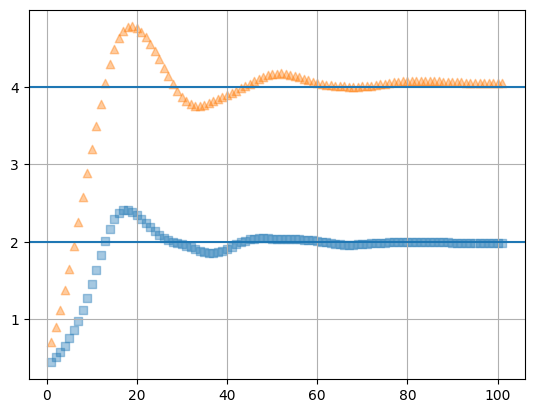

In [28]:
k = 2
lambd = 4
params = train_and_plot_params(tfd.Weibull(k, lambd), params=(k, lambd))

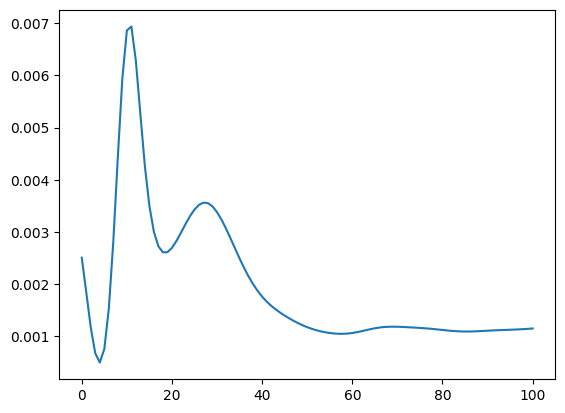

In [32]:
var_epoch = [np.var(params[i]["param_1"][:, -1, 0]) for i in range(len(params))]
plt.plot(var_epoch)
plt.show()

Model will train with a Gamma distribution
Loss at epoch 0: 1.02
Loss at epoch 10: 0.68
Loss at epoch 20: 0.69
Loss at epoch 30: 0.66
Loss at epoch 40: 0.65
Loss at epoch 50: 0.65
Loss at epoch 60: 0.65
Loss at epoch 70: 0.65
Loss at epoch 80: 0.65
Loss at epoch 90: 0.65
Loss at epoch 100: 0.65


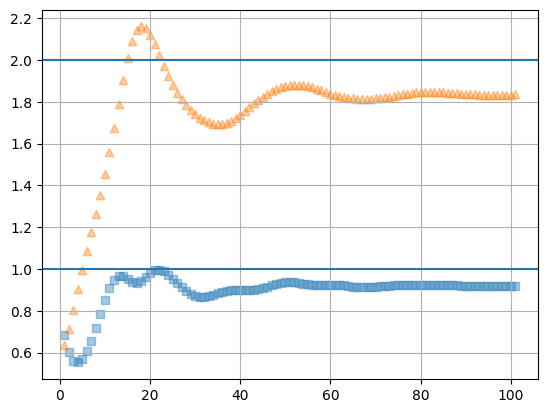

In [38]:
alpha = 1
beta = 2
params = train_and_plot_params(tfd.Gamma(alpha, beta), train_dist=Gamma,
                      samples_shape=(100, 100), params=(alpha, beta));

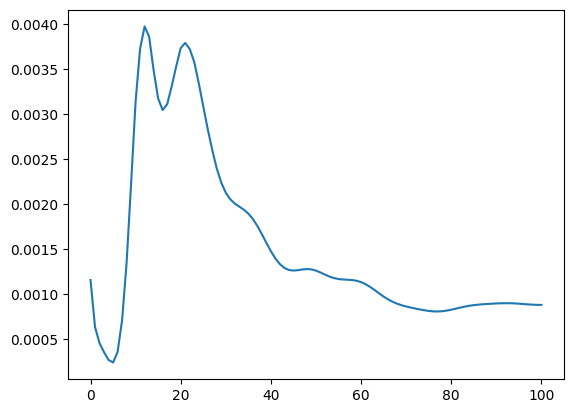

In [39]:
var_epoch = [np.var(params[i]["param_1"][:, -1, 0]) for i in range(len(params))]
plt.plot(var_epoch)
plt.show()

Model will train with a Gamma distribution
Loss at epoch 0: 0.90
Loss at epoch 10: 0.65
Loss at epoch 20: 0.63
Loss at epoch 30: 0.63
Loss at epoch 40: 0.62
Loss at epoch 50: 0.61
Loss at epoch 60: 0.61
Loss at epoch 70: 0.61
Loss at epoch 80: 0.61
Loss at epoch 90: 0.61
Loss at epoch 100: 0.61
Loss at epoch 110: 0.61
Loss at epoch 120: 0.61
Loss at epoch 130: 0.61
Loss at epoch 140: 0.61
Loss at epoch 150: 0.61


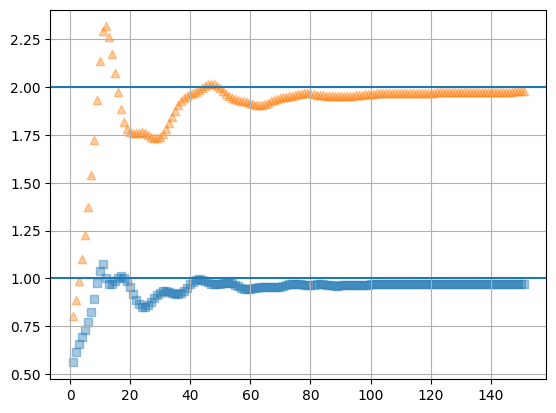

In [42]:
alpha = 1
beta = 2
params = train_and_plot_params(tfd.Gamma(alpha, beta), train_dist=Gamma,
                      num_epochs=150,
                      samples_shape=(10, 500), params=(alpha, beta));

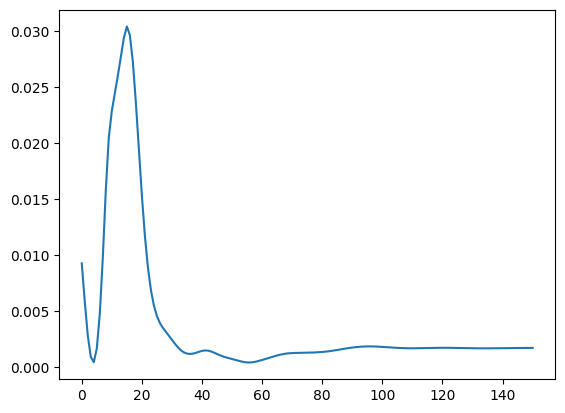

In [43]:
var_epoch = [np.var(params[i]["param_1"][:, -1, 0]) for i in range(len(params))]
plt.plot(var_epoch)
plt.show()

Model will train with a Gamma distribution
Loss at epoch 0: 1.16
Loss at epoch 10: 0.45
Loss at epoch 20: 0.38
Loss at epoch 30: 0.37
Loss at epoch 40: 0.35
Loss at epoch 50: 0.35
Loss at epoch 60: 0.34
Loss at epoch 70: 0.34
Loss at epoch 80: 0.34
Loss at epoch 90: 0.34
Loss at epoch 100: 0.34
Loss at epoch 110: 0.34
Loss at epoch 120: 0.34
Loss at epoch 130: 0.34
Loss at epoch 140: 0.34
Loss at epoch 150: 0.34
Loss at epoch 160: 0.34
Loss at epoch 170: 0.34
Loss at epoch 180: 0.34
Loss at epoch 190: 0.34
Loss at epoch 200: 0.34


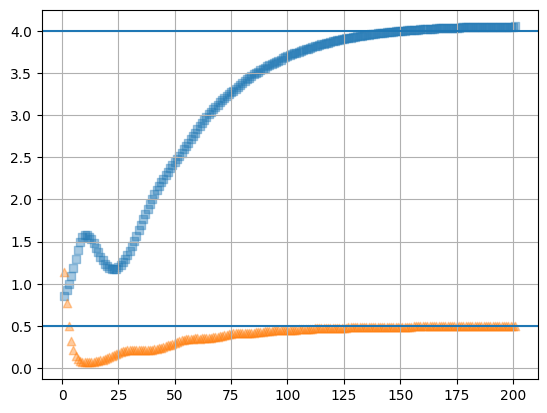

In [44]:
alpha = 4
beta = 0.5
dist = tfd.Gamma(alpha, beta)
params = train_and_plot_params(dist, train_dist=Gamma, num_epochs=200,
                      samples_shape=(10, 1000), params=(alpha, beta));

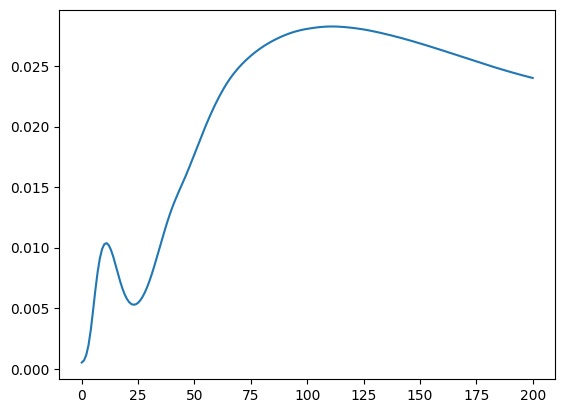

In [45]:
var_epoch = [np.var(params[i]["param_1"][:, -1, 0]) for i in range(len(params))]
plt.plot(var_epoch)
plt.show()

### Avec une loi de mélange

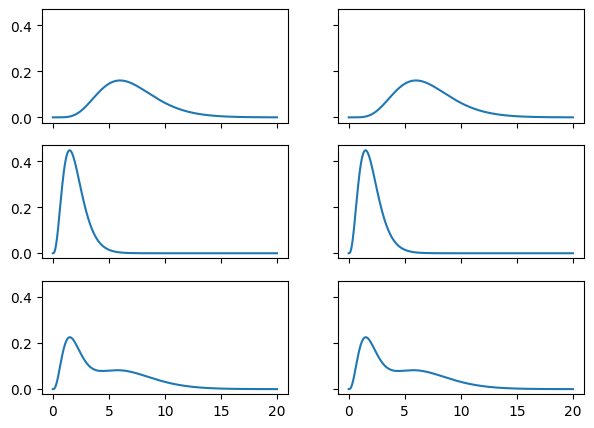

In [46]:
g1 = tfd.Gamma(7., 1.)
g2 = tfd.Gamma(4., 2.)
mix1 = tfd.MixtureSameFamily(
    tfd.Categorical(probs=[0.5, 0.5]),
    tfd.Gamma([7., 4.], [1., 2.])
)

g1 = Gamma(7., 1.)
g2 = Gamma(4., 2.)
mix2 = Mixture([0.5, 0.5], Gamma([7., 4.], [1., 2.]))

fig, axes = plt.subplots(3, 2, figsize=(7, 5),
                         sharex=True, sharey=True)

x = np.linspace(0, 20, 1000).astype(np.float32)

axes[0, 0].plot(x, g1.prob(x))
axes[1, 0].plot(x, g2.prob(x))
axes[2, 0].plot(x, mix1.prob(x))

axes[0, 1].plot(x, g1.prob(x))
axes[1, 1].plot(x, g2.prob(x))
axes[2, 1].plot(x, mix2.prob(x))

plt.show()

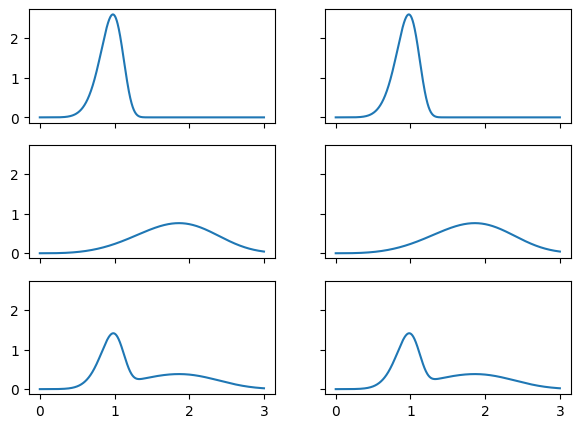

In [70]:
g1 = tfd.Weibull(7., 1.)
g2 = tfd.Weibull(4., 2.)
mix1 = tfd.MixtureSameFamily(
    tfd.Categorical(probs=[0.5, 0.5]),
    tfd.Weibull([7., 4.], [1., 2.])
)

g1 = Weibull(7., 1.)
g2 = Weibull(4., 2.)
mix2 = Mixture([0.5, 0.5], Weibull([7., 4.], [1., 2.]))

fig, axes = plt.subplots(3, 2, figsize=(7, 5),
                         sharex=True, sharey=True)

x = np.linspace(0, 3, 1000).astype(np.float32)

axes[0, 0].plot(x, g1.prob(x))
axes[1, 0].plot(x, g2.prob(x))
axes[2, 0].plot(x, mix1.prob(x))

axes[0, 1].plot(x, g1.prob(x))
axes[1, 1].plot(x, g2.prob(x))
axes[2, 1].plot(x, mix2.prob(x))

plt.show()

In [121]:
def train_and_plot_mix(samples_dist, num_comp, samples_shape=(100, 100), train_dist=Weibull, num_epochs=100, xlim=(0, 15)):
    inter_times = tf.cast(samples_dist.sample([100, 100]), dtype=tf.float32)
    arrival_times = np.cumsum(inter_times, axis=-1)
    eps = 1e-8
    t_end = np.min(arrival_times[:, -1]) - eps
    seq_lengths = np.sum(arrival_times < t_end, axis=-1)

    model = Model(context_size=32, dist=train_dist, num_cmpts=num_comp)
    model.fit(num_epochs, inter_times, seq_lengths, t_end)

    epochs = range(len(model.params))
    weight_list = [model.params[i]["weights"][:, -1] for i in epochs]
    param_1_list = [model.params[i]["param_1"][:, -1] for i in epochs]
    param_2_list = [model.params[i]["param_2"][:, -1] for i in epochs]

    weights = weight_list[-1][-1]
    param_1 = param_1_list[-1][-1]
    param_2 = param_2_list[-1][-1]

    mix_pred = Mixture(weights, train_dist(param_1, param_2))

    x = np.linspace(0, 15, 1000).astype(np.float32)
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
    axes[0].plot(x, samples_dist.prob(x))
    axes[0].set_xlim(xlim)
    axes[1].plot(x, mix_pred.prob(x))
    plt.show()

    return model.params

Model will train with a mixture of 2 Gamma distributions
Loss at epoch 0: 1.02
Loss at epoch 10: 0.61
Loss at epoch 20: 0.56
Loss at epoch 30: 0.55
Loss at epoch 40: 0.54
Loss at epoch 50: 0.54
Loss at epoch 60: 0.54
Loss at epoch 70: 0.54
Loss at epoch 80: 0.54
Loss at epoch 90: 0.54
Loss at epoch 100: 0.54


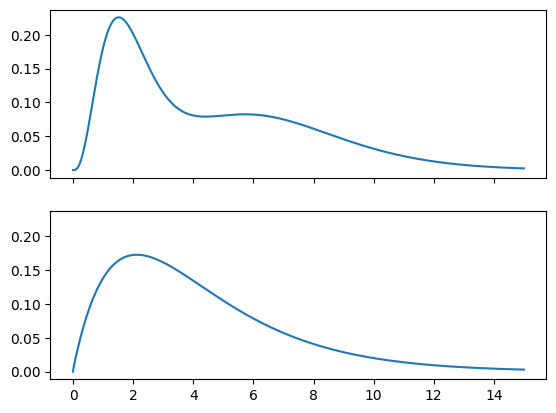

In [60]:
mix = tfd.MixtureSameFamily(
    tfd.Categorical(probs=[0.5, 0.5]),
    tfd.Gamma([7., 4.], [1., 2.])
)
train_and_plot_mix(mix, 2, train_dist=Gamma, num_epochs=100);

Model will train with a mixture of 2 Gamma distributions
Loss at epoch 0: 1.28
Loss at epoch 10: 0.62
Loss at epoch 20: 0.56
Loss at epoch 30: 0.56
Loss at epoch 40: 0.55
Loss at epoch 50: 0.55
Loss at epoch 60: 0.55
Loss at epoch 70: 0.54
Loss at epoch 80: 0.54
Loss at epoch 90: 0.54
Loss at epoch 100: 0.54
Loss at epoch 110: 0.54
Loss at epoch 120: 0.54
Loss at epoch 130: 0.54
Loss at epoch 140: 0.54
Loss at epoch 150: 0.54
Loss at epoch 160: 0.54
Loss at epoch 170: 0.53
Loss at epoch 180: 0.53
Loss at epoch 190: 0.53
Loss at epoch 200: 0.53


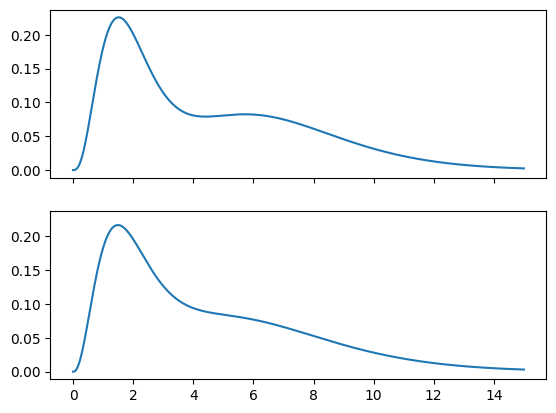

In [61]:
train_and_plot_mix(mix, 2, train_dist=Gamma, num_epochs=200);

Model will train with a mixture of 10 Gamma distributions
Loss at epoch 0: 0.77
Loss at epoch 10: 0.58
Loss at epoch 20: 0.55
Loss at epoch 30: 0.55
Loss at epoch 40: 0.54
Loss at epoch 50: 0.54
Loss at epoch 60: 0.54
Loss at epoch 70: 0.54
Loss at epoch 80: 0.54
Loss at epoch 90: 0.53
Loss at epoch 100: 0.53


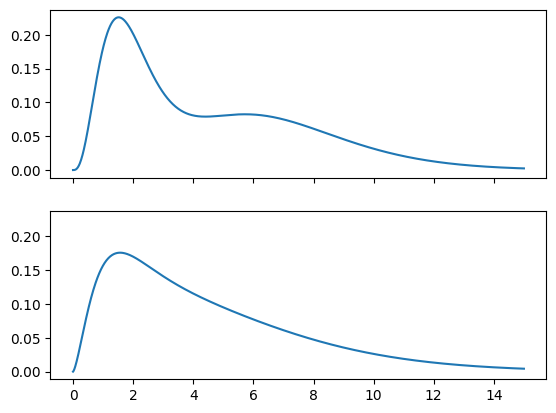

In [62]:
train_and_plot_mix(mix, 10, train_dist=Gamma, num_epochs=100);

Model will train with a mixture of 3 Weibull distributions
Loss at epoch 0: 0.78
Loss at epoch 10: 0.58
Loss at epoch 20: 0.51
Loss at epoch 30: 0.48
Loss at epoch 40: 0.47
Loss at epoch 50: 0.47
Loss at epoch 60: 0.46
Loss at epoch 70: 0.46
Loss at epoch 80: 0.46
Loss at epoch 90: 0.45
Loss at epoch 100: 0.44


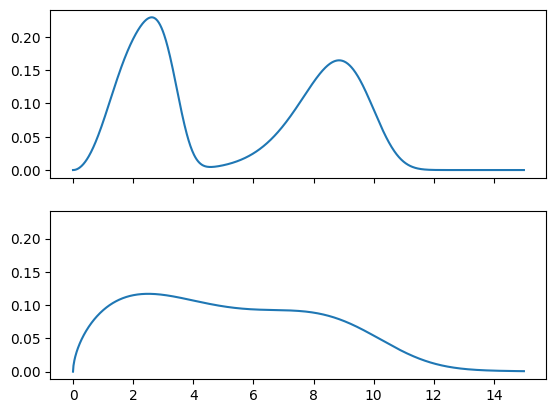

In [67]:
mix = tfd.MixtureSameFamily(
    tfd.Categorical(probs=[0.3, 0.2, 0.5]),
    tfd.Weibull([5, 3., 8.], [3., 2., 9.])
)
train_and_plot_mix(mix, 3, num_epochs=100);

Model will train with a mixture of 3 Weibull distributions
Loss at epoch 0: 0.70
Loss at epoch 10: 0.55
Loss at epoch 20: 0.49
Loss at epoch 30: 0.47
Loss at epoch 40: 0.47
Loss at epoch 50: 0.47
Loss at epoch 60: 0.47
Loss at epoch 70: 0.47
Loss at epoch 80: 0.46
Loss at epoch 90: 0.44
Loss at epoch 100: 0.43
Loss at epoch 110: 0.42
Loss at epoch 120: 0.42
Loss at epoch 130: 0.42
Loss at epoch 140: 0.42
Loss at epoch 150: 0.42
Loss at epoch 160: 0.42
Loss at epoch 170: 0.42
Loss at epoch 180: 0.42
Loss at epoch 190: 0.42
Loss at epoch 200: 0.42


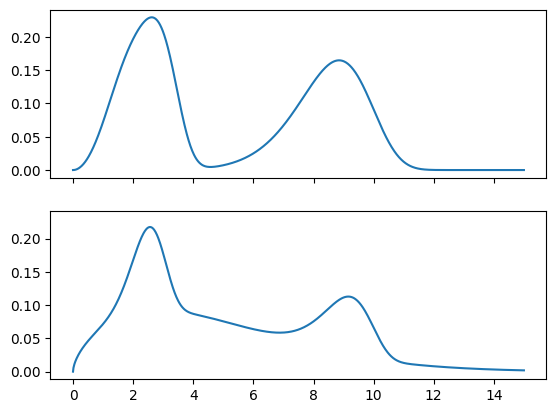

In [68]:
train_and_plot_mix(mix, 3, num_epochs=200);

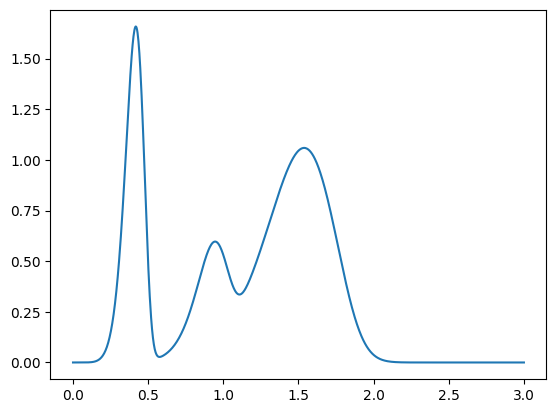

In [107]:
def get_random_mix(base=tfd.Weibull):
    num_comp = np.random.randint(low=1, high=8, size=1)
    rands = np.random.randint(low=1, high=10, size=num_comp)
    weights = rands / np.sum(rands)
    param_1 = np.random.uniform(3, 10, num_comp)
    param_2 = np.random.uniform(0, 2, num_comp)
    mix = tfd.MixtureSameFamily(tfd.Categorical(probs=weights), base(param_1, param_2))
    x = np.linspace(0, 3, 1000)
    plt.plot(x, mix.prob(x))
    plt.show()
    return mix

mix = get_random_mix()

Model will train with a mixture of 2 Weibull distributions
Loss at epoch 0: 1.38
Loss at epoch 10: 0.75
Loss at epoch 20: 0.65
Loss at epoch 30: 0.55
Loss at epoch 40: 0.53
Loss at epoch 50: 0.52


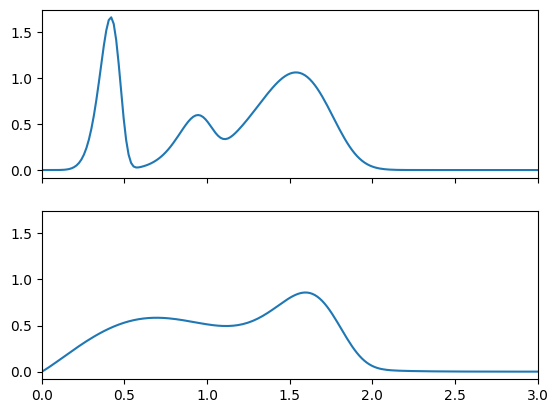

In [123]:
train_and_plot_mix(mix, 2, num_epochs=50, xlim=(0, 3));

Model will train with a mixture of 5 Weibull distributions
Loss at epoch 0: 1.27
Loss at epoch 10: 0.76
Loss at epoch 20: 0.67
Loss at epoch 30: 0.62
Loss at epoch 40: 0.57
Loss at epoch 50: 0.47


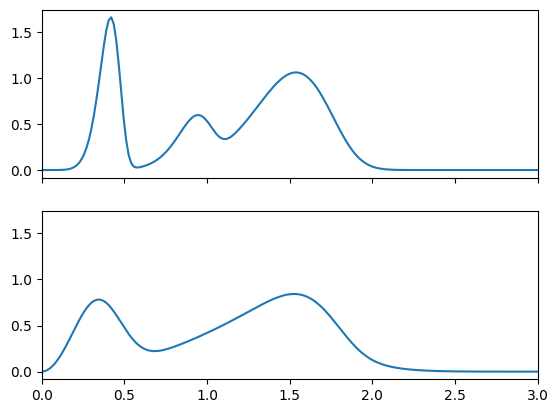

In [124]:
train_and_plot_mix(mix, 5, num_epochs=50, xlim=(0, 3));

Model will train with a mixture of 5 Weibull distributions
Loss at epoch 0: 1.31
Loss at epoch 10: 0.83
Loss at epoch 20: 0.69
Loss at epoch 30: 0.62
Loss at epoch 40: 0.56
Loss at epoch 50: 0.50
Loss at epoch 60: 0.44
Loss at epoch 70: 0.38
Loss at epoch 80: 0.37
Loss at epoch 90: 0.36
Loss at epoch 100: 0.36
Loss at epoch 110: 0.36
Loss at epoch 120: 0.36
Loss at epoch 130: 0.36
Loss at epoch 140: 0.36
Loss at epoch 150: 0.36
Loss at epoch 160: 0.36
Loss at epoch 170: 0.36
Loss at epoch 180: 0.36
Loss at epoch 190: 0.36
Loss at epoch 200: 0.36


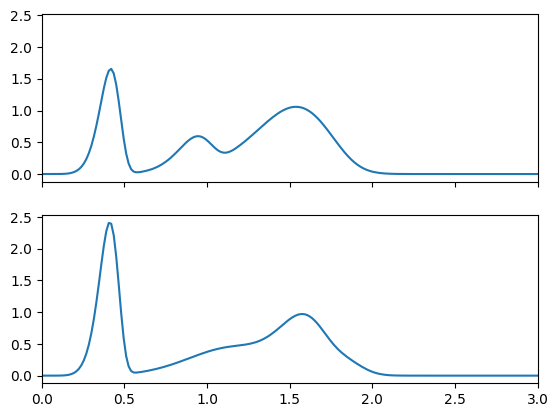

In [126]:
train_and_plot_mix(mix, 5, num_epochs=200, xlim=(0, 3));

Model will train with a mixture of 10 Weibull distributions
Loss at epoch 0: 1.31
Loss at epoch 10: 0.85
Loss at epoch 20: 0.69
Loss at epoch 30: 0.58
Loss at epoch 40: 0.48
Loss at epoch 50: 0.43
Loss at epoch 60: 0.41
Loss at epoch 70: 0.38
Loss at epoch 80: 0.35
Loss at epoch 90: 0.34
Loss at epoch 100: 0.33
Loss at epoch 110: 0.33
Loss at epoch 120: 0.33
Loss at epoch 130: 0.33
Loss at epoch 140: 0.33
Loss at epoch 150: 0.33
Loss at epoch 160: 0.33
Loss at epoch 170: 0.33
Loss at epoch 180: 0.33
Loss at epoch 190: 0.33
Loss at epoch 200: 0.33


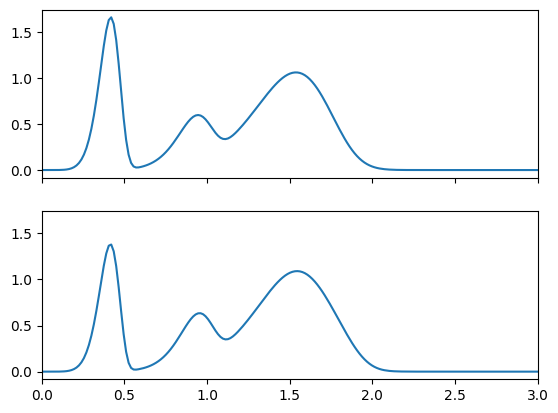

In [127]:
train_and_plot_mix(mix, 10, num_epochs=200, xlim=(0, 3));

### Données ETAS

In [141]:
data = etas_pkl.gen_dataset("--verbose --print_config --num_seqs 2000 --max_len 600",
                              save=True, filename="etas.pkl")

Program configuration:
  --tmax		100
  --mu			1
  --alpha		2
  --bar_n		0.9
  --p			1.1
  --c			1e-09
  --beta		2.30259

  --generate_seqs	true
  --num_seqs		2000
  --max_len		600

  --filename		data.csv
  --dirname		data_temp_seqs

  --verbose		true
Generating sequences...
[========================================] 100% 


In [142]:
len(data)

2000

In [143]:
type(data[0])

pandas.core.frame.DataFrame

In [144]:
data[0].head()

,TIME,MAG,PARENT
ID,,,
1,0.72334,0.131828,0
2,4.30223,0.542481,0
3,5.49479,0.021904,0
4,6.89605,0.016254,0
5,7.49238,0.039138,0


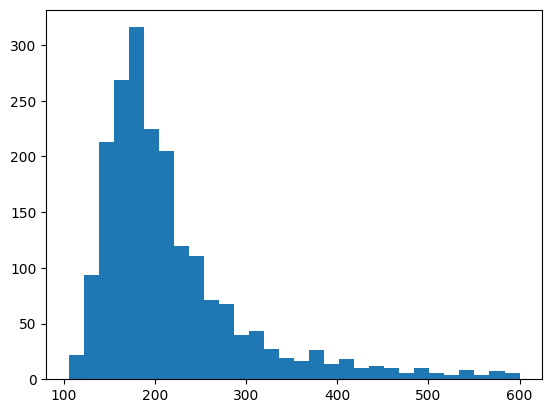

In [145]:
plt.hist([data[i].shape[0] for i in range(len(data))],
         bins=30)
plt.show()